#**Baseline Evaluation for Early Diagnosis of Parkinson’s Disease Progression**
> **Author:** Dharesh Vadalia


---


##**Introduction**
Parkinson's Disease is a neuro degerative disorder  caused due to loss of dopaminergic neuron in the substantia nigra located at midbrain, disturbing the patients control over motor movements and non-motor senses. During the early stages of Parkinson's Disease, patients may experience bradykinesia, resting tremors, anxiety, disturbance in sleeps, depression, vocal impairment or fatigue.These symptoms worsen gradually, causing permanent damage to patient’s quality of life. Patient at an adult age of 60 and above tends to develop visible disabilities, such as postural instability, freeze of gait and muscle rigidity.

\
**Objective** \
1.  Study various clinical assessment techniques designed by makers of PD biomarkers and identify impact factor of various contributing clinical cohorts for building machine learning model.
2.  Predict risk of PD progression based on evaluation of baseline charachteristic captured for patients. 

\
**Research Question**\
How well can combined analysis of clinical biomarkers help identify risk of Parkinson’s Disease progression at prodromal stage?

\
**Source of Data**\
Parkinson's Progression Makers Initiative (PPMI) (http://www.ppmi-info.org), Michael J. Fox Foundation for Parkinson’s Research.\
Data is fetched from PPMI data repository via dedicated pypmi API package (https://pypmi.readthedocs.io/en/latest/index.html).

##**Implementation**

###Importing Necessary Libraries

In [ ]:
!pip install pypmi

     |████████████████████████████████| 51kB 1.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import pypmi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
from sklearn import mixture
import itertools
from sklearn import metrics
%matplotlib inline
sns.set()
import random
random.seed(123)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Data Loading and Pre-Processing

Downloading study data from PPMI repository via pypmi ***fetch_studydata()*** API.\
\
**Note: In case of poor netwrok connection API connection may timeout while downloading the dataset. In such case re-run the line of code. Download file size is approx 20 MB

In [ ]:
pypmi.fetch_studydata('all', user='{your ppmi user id}', password='{your password}')

Fetching authentication key for data download...
Requesting 113 datasets for download...


Fetching data file(s): 20.3MB [00:37, 535kB/s]


['/content/AV-133_Image_Metadata.csv',
 '/content/AV-133_Imaging.csv',
 '/content/AV-133_SBR_Results.csv',
 '/content/AV-133_Subject_Eligibility.csv',
 '/content/Adverse_Event_Log.csv',
 '/content/Benton_Judgment_of_Line_Orientation.csv',
 '/content/Blood_Chemistry___Hematology.csv',
 '/content/Center-Subject_List.csv',
 '/content/Cognitive_Categorization.csv',
 '/content/Clinical_Diagnosis_and_Management.csv',
 '/content/Clinical_Labs.csv',
 '/content/Code_List.csv',
 '/content/Cognitive_Assessments.csv',
 '/content/Conclusion_of_Study_Participation.csv',
 '/content/Concomitant_Medications.csv',
 '/content/Randomization_table.csv',
 '/content/Contact_Information_FOUND.csv',
 '/content/Contact_Information_Brain_Bank.csv',
 '/content/Current_Biospecimen_Analysis_Results.csv',
 '/content/Current_Medical_Conditions_Log.csv',
 '/content/DNA_Sample_Collection.csv',
 '/content/DTI_Regions_of_Interest.csv',
 '/content/DaTSCAN_SPECT_Visual_Interpretation_Assessment.csv',
 '/content/DaTscan_Ima

A **Dictionary** is created with important covariates which are to be extracted from downloaded **.csv** files. Each **.csv** file represents different pre-clinical assessment test conducted to access patients condition against biomarkers of Parkinson's Disease .

In [ ]:
'''

PATNO: Unique ID assigned to each patient

EVENT_ID: Patients Visit ID for recurring assessment carried out every month
{BL(Baseline), V01(visit 1), V02, V03, V04, V05, V06, V07, V08, V09, V10, V11, V12}

(PATNO + EVENT_ID) is unique to each record in all motor and non-motor assessment tests.

'''
covariates = {}

########## SUBJECT CHARACHTERISTIC AND MEDICAL HISTORY ##########

#Patients enrolment status
covariates["pat_status"] = ["PATNO", "RECRUITMENT_CAT", "IMAGING_CAT", "ENROLL_DATE", "ENROLL_CAT"]
#Demographic infomation of patients 
covariates["pat_demographics"] = ["PATNO", "BIRTHDT", "GENDER", "APPRDX", "CURRENT_APPRDX", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAHAWOPI", "RAWHITE", "RANOS"]
#Family History Table Covariates
covariates["pat_family_history"] = ["PATNO", "BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"]

########## MOTOR AND NON-MOTOR ASSESSMENTS ##########

#UPDRS - Unified Parkinson’s Disease Rating Scale (Part 1 - Part 4)
covariates["updrs1"] = ["PATNO", "EVENT_ID", "INFODT", "NP1COG", "NP1HALL", "NP1DPRS", "NP1ANXS", "NP1APAT", "NP1DDS"]
covariates["updrs1pq"] = ["PATNO", "EVENT_ID", "NP1SLPN", "NP1SLPD", "NP1PAIN", "NP1URIN", "NP1CNST", "NP1LTHD", "NP1FATG"]
covariates["updrs2pq"] = ["PATNO", "EVENT_ID", "NP2SPCH", "NP2SALV", "NP2SWAL", "NP2EAT", "NP2DRES", "NP2HYGN", "NP2HWRT", "NP2HOBB", "NP2TURN", "NP2TRMR", "NP2RISE", "NP2WALK", "NP2FREZ"]
covariates["updrs3"] = ["PATNO", "EVENT_ID", "PAG_NAME", "EXAMTM", "NP3SPCH", "NP3FACXP", "NP3RIGN", "NP3RIGRU", "NP3RIGLU", "PN3RIGRL", "NP3RIGLL", "NP3FTAPR", "NP3FTAPL", "NP3HMOVR", "NP3HMOVL", "NP3PRSPR", "NP3PRSPL", "NP3TTAPR", "NP3TTAPL", "NP3LGAGR", "NP3LGAGL", "NP3RISNG", "NP3GAIT", "NP3FRZGT", "NP3PSTBL", "NP3POSTR", "NP3BRADY", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", "NP3RTALJ", "NP3RTCON", "DYSKPRES", "DYSKIRAT", "NHY", "ANNUAL_TIME_BTW_DOSE_NUPDRS", "ON_OFF_DOSE", "PD_MED_USE"]
# MOCA - Montreal Cognitive Assessment
covariates["moca"] = ["PATNO", "EVENT_ID", "MCAALTTM", "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO", "MCACAMEL", "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC", "MCAVFNUM", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3", "MCAREC4", "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY", "MCAPLACE", "MCACITY", "MCATOT"]
# STAI - State-Trait Anxiety Inventory Test
covariates["stai"] = [ "PATNO", "EVENT_ID", "STAIAD1", "STAIAD2", "STAIAD3", "STAIAD4", "STAIAD5", "STAIAD6", "STAIAD7", "STAIAD8", "STAIAD9", "STAIAD10", "STAIAD11", "STAIAD12", "STAIAD13", "STAIAD14", "STAIAD15", "STAIAD16", "STAIAD17", "STAIAD18", "STAIAD19", "STAIAD20", "STAIAD21", "STAIAD22", "STAIAD23", "STAIAD24", "STAIAD25", "STAIAD26", "STAIAD27", "STAIAD28", "STAIAD29", "STAIAD30", "STAIAD31", "STAIAD32", "STAIAD33", "STAIAD34", "STAIAD35", "STAIAD36", "STAIAD37", "STAIAD38", "STAIAD39", "STAIAD40" ]
# GDS - Geriatric Depression Scale
covariates["gds"] = ["PATNO", "EVENT_ID", "GDSSATIS", "GDSDROPD", "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", "GDSHOPLS", "GDSBETER"]
# QUIP- Questionnaire for Impulsive-compulsive Disorder in Parkinson’s Disease 
covariates["quip"] = [ "PATNO", "EVENT_ID", "TMGAMBLE", "CNTRLGMB", "TMSEX", "CNTRLSEX", "TMBUY", "CNTRLBUY", "TMEAT", "CNTRLEAT", "TMTORACT", "TMTMTACT", "TMTRWD" ]
# SCOPA-AUT - Scale for Outcomes in Parkinson’s Disease – Autonomic Dysfunction Test 
covariates["scopa_aut"] = [ "PATNO", "EVENT_ID", "SCAU1", "SCAU2", "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU23A", "SCAU23AT", "SCAU24", "SCAU25", "SCAU26A", "SCAU26AT", "SCAU26B", "SCAU26BT", "SCAU26C", "SCAU26CT", "SCAU26D", "SCAU26DT" ]
# SFT - Semantic Fluency Test
covariates["sft"] = [ "PATNO", "EVENT_ID", "VLTANIM", "VLTVEG", "VLTFRUIT" ]
# REM-RBD - Rapid Eye Movement Sleep Behavior Disorder Test
covariates["rem_rbd"] = [ "PATNO", "EVENT_ID", "DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB", "STROKE", "HETRA", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM" ]
#EPWORTH - Epworth Sleepness Scale
covariates["epworth"] = ["PATNO", "EVENT_ID", "ESS1", "ESS2", "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"]
# HVLT- Hopkins Verbal Learning Test
covariates["hvlt"] = ["PATNO", "EVENT_ID", "HVLTRT1", "HVLTRT2", "HVLTRT3", "HVLTRDLY", "HVLTREC", "HVLTFPRL", "HVLTFPUN"]
# LNS - Letter Number Sequencing Test
covariates["lns"] = ["PATNO", "EVENT_ID","LNS_TOTRAW"]
# Neurological exam: Cranial Nerves Test
covariates["neuro_cranial"] = ["PATNO", "EVENT_ID","CN1RSP", "CN2RSP", "CN346RSP", "CN5RSP", "CN7RSP", "CN8RSP", "CN910RSP", "CN11RSP", "CN12RSP"]
# SDM - Symbol Digit Modalities Test
covariates["sdm"] = [ "PATNO", "EVENT_ID", "SDMTOTAL"] 
# Neuropsychological Test - (Line Orientation)
covariates["benton"] = ["PATNO", "EVENT_ID", "JLO_TOTRAW"]


Extracting required data from **.csv** files into dataframes

In [ ]:
path=''

########## SUBJECT CHARACHTERISTIC AND MEDICAL HISTORY ##########
pat_status = pd.read_csv(path+"Patient_Status.csv", index_col=["PATNO"], usecols=covariates["pat_status"])
pat_demographics = pd.read_csv(path+"Screening___Demographics.csv", index_col=["PATNO"], usecols=covariates["pat_demographics"])
pat_family_history = pd.read_csv(path+"Family_History__PD_.csv", index_col=["PATNO"], usecols=covariates["pat_family_history"])

########## MOTOR AND NON-MOTOR ASSESSMENTS ##########
updrs1 = pd.read_csv(path+"MDS_UPDRS_Part_I.csv", index_col=["PATNO", "EVENT_ID"], parse_dates=["INFODT"], usecols=covariates["updrs1"])
updrs1pq = pd.read_csv(path+"MDS_UPDRS_Part_I__Patient_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["updrs1pq"])
updrs2pq = pd.read_csv(path+"MDS_UPDRS_Part_II__Patient_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["updrs2pq"])
updrs3_temp = pd.read_csv(path+"MDS_UPDRS_Part_III.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["updrs3"])
updrs3 = updrs3_temp[updrs3_temp.PAG_NAME == 'NUPDRS3'] # pre med dose 
updrs3a = updrs3_temp[updrs3_temp.PAG_NAME == 'NUPDRS3A'] # post med dose  
moca = pd.read_csv(path+"Montreal_Cognitive_Assessment__MoCA_.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["moca"])
stai = pd.read_csv(path+"State-Trait_Anxiety_Inventory.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["stai"])
gds = pd.read_csv(path+"Geriatric_Depression_Scale__Short_.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["gds"])
quip = pd.read_csv(path+"QUIP_Current_Short.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["quip"])
scopa_aut = pd.read_csv(path+"SCOPA-AUT.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["scopa_aut"])
sft = pd.read_csv(path+"Semantic_Fluency.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["sft"])
rem_rbd = pd.read_csv(path+"REM_Sleep_Disorder_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["rem_rbd"])
epworth = pd.read_csv(path+"Epworth_Sleepiness_Scale.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["epworth"])
hvlt = pd.read_csv(path+"Hopkins_Verbal_Learning_Test.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["hvlt"])
lns = pd.read_csv(path+"Letter_-_Number_Sequencing__PD_.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["lns"])
neuro_cranial = pd.read_csv(path+"Neurological_Exam_-_Cranial_Nerves.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["neuro_cranial"])
sdm = pd.read_csv(path+"Symbol_Digit_Modalities.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["sdm"])
benton = pd.read_csv(path+"Benton_Judgment_of_Line_Orientation.csv", index_col=["PATNO", "EVENT_ID"], usecols=covariates["benton"])


###Exploratory Data Analysis

Detailed analysis of fetched data is conducted to obtain better understanding on characteristic and quality of fetched data.

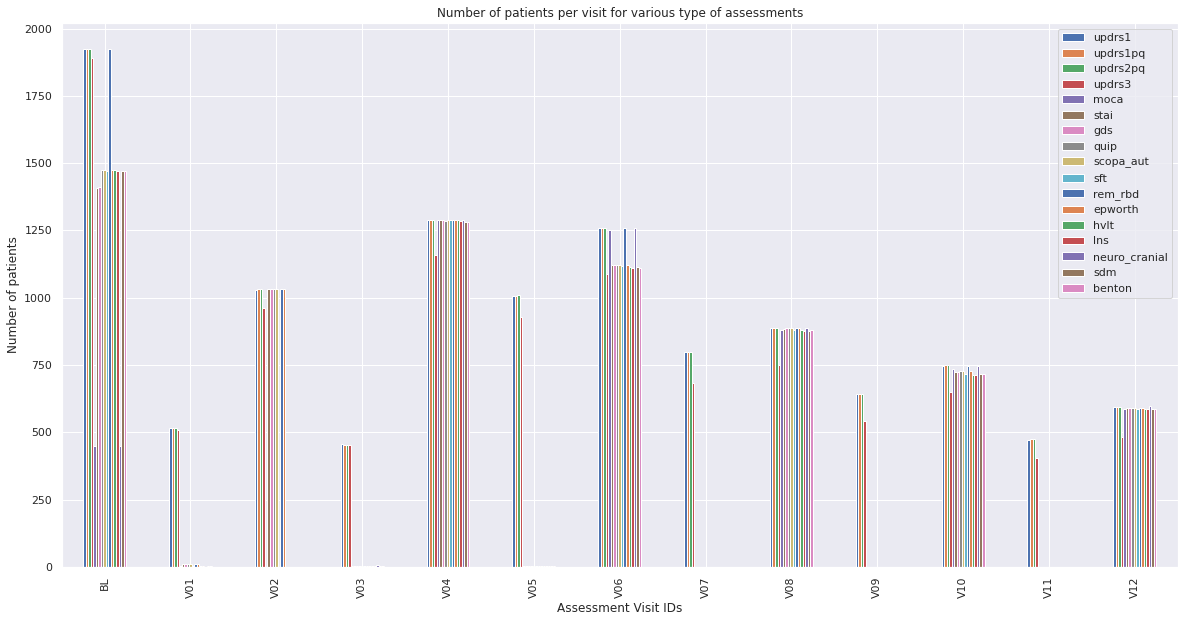

In [ ]:
list_of_datasets = ['updrs1', 'updrs1pq', 'updrs2pq', 'updrs3', 'moca', 'stai', 'gds', 'quip', 'scopa_aut', 
            'sft', 'rem_rbd', 'epworth', 'hvlt', 'lns', 'neuro_cranial', 'sdm', 'benton']

visit_ids = ['BL', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12']
last_visit = visit_ids[-1] #V12


init_dataset = eval(list_of_datasets[0]).reset_index()
plot = init_dataset.reset_index().groupby('EVENT_ID').size().reset_index().rename(columns={0:list_of_datasets[0]})

for dataset in list_of_datasets[1:]:    
    dataset_idx = eval(dataset).reset_index()
    temp_plot = dataset_idx.reset_index().groupby('EVENT_ID').size().reset_index().rename(columns={0:dataset})
    
    plot = plot.merge(temp_plot, on='EVENT_ID', how='outer')
    
plot = plot.set_index('EVENT_ID').loc[visit_ids].plot(kind='bar', title="Number of patients per visit for various type of assessments",
                                                      figsize=(20, 10))
plot.set_ylabel("Number of patients");
plot.set_xlabel("Assessment Visit IDs");

From above visualisation, it can be inferred that as we move towards last visit of assessment, steep decline in number of participant can be seen. Also for various tests are not mandatory to be conducted during each visit. Therefore, based presented data instead of selecting each visit, specific visits with most test data is selected. That is BL, V02, V04, V06, V08, V10, V12

Records of data for all the essential covariates identified in selected list of clinical assessment is merged over unique index key defined on patient id and visit id for the filtered list of patients.

In [ ]:
#Selecting visits of interest
visit_ids_of_interest = ['BL', 'V02', 'V04', 'V06', 'V08', 'V10', 'V12']
last_visit = visit_ids_of_interest[-1] #V12

# selecting patient data who participated from BL to last_visit
dataset_temp = eval(list_of_datasets[0]).reset_index()
list_of_ptnno = dataset_temp[ dataset_temp.EVENT_ID == last_visit ]['PATNO']

for dataset in list_of_datasets:
    dataset_temp = eval(dataset).reset_index()
    patno_temp = dataset_temp[ dataset_temp.EVENT_ID == last_visit ]['PATNO']
    list_of_ptnno = list_of_ptnno[ list_of_ptnno.isin(patno_temp)]

print(f'Total {list_of_ptnno.size} number of patients who participated till last visit for all assessments')

Total 476 number of patients who participated till last visit for all assessments


In [ ]:
# constructing the data_visits dictionary with all the information
merged_data = {}
status = pat_status[pat_status.index.isin(list_of_ptnno)].ENROLL_CAT
demographics = pat_demographics[pat_demographics.index.isin(list_of_ptnno)]
merged_data["info"] = pd.concat([status, demographics], axis=1)

for dataset in list_of_datasets:    
    dataset_temp = eval(dataset).reset_index()
    merged_data[dataset] = dataset_temp[ dataset_temp['PATNO'].isin(list_of_ptnno) & dataset_temp['EVENT_ID'].isin(visit_ids_of_interest) ]

merged_data["info"].ENROLL_CAT.reset_index().groupby("ENROLL_CAT").size()

ENROLL_CAT
GENPD         8
GENUN         6
HC          154
PD          294
PRODROMA     10
REGPD         1
SWEDD         3
dtype: int64

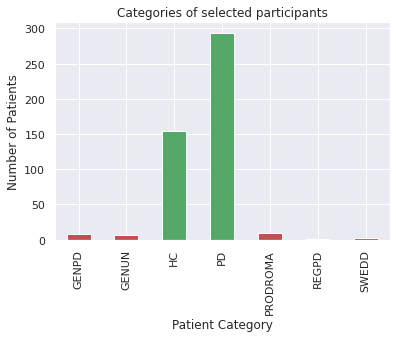

In [ ]:
plot_1 = merged_data["info"].ENROLL_CAT.reset_index().groupby("ENROLL_CAT").size().plot(kind='bar',
                                                                                        title="Categories of selected participants", 
                                                                                        color = ['r','r','g','g','r','r','r'])
plot_1.set_ylabel("Number of Patients"); 
plot_1.set_xlabel("Patient Category");




Above bar graph represents the category of participating patients. It can be infered that most of the participants fall under Healthy Control(HC) and Parkinsons Disease (PD) category. Thus we will consider records from this two categories for training model. 

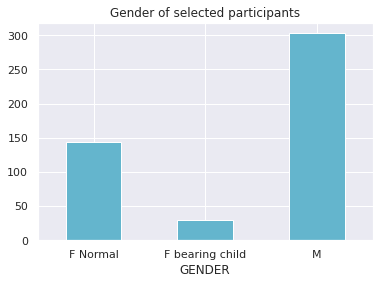

In [ ]:
merged_data["info"].GENDER.replace([0, 1, 2], ['F bearing child', 'F Normal', 'M']).reset_index().groupby("GENDER").size().plot(kind='bar', title="Gender of selected participants", rot=0, color = 'c');

Above bar graph represent distribution of participants on basis of gender. Also, there is a different category marked fro female participant who are pregnent. It can be depicted that their are higher number of male participants in this data.

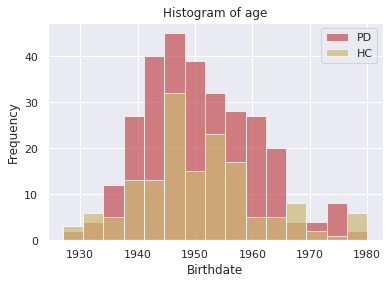

In [ ]:
hc_birthdt = merged_data["info"].BIRTHDT.reset_index()[merged_data["info"].reset_index()['ENROLL_CAT'] == 'HC'].rename(columns={'BIRTHDT':'HC'})
pd_birthdt = merged_data["info"].BIRTHDT.reset_index()[merged_data["info"].reset_index()['ENROLL_CAT'] == 'PD'].rename(columns={'BIRTHDT':'PD'})
concat_birthdt = pd.concat([pd_birthdt.PD, hc_birthdt.HC], axis=1)
plot_3 = concat_birthdt.plot(kind='hist', title="Histogram of age", alpha=0.7, bins=15, ax=plt.gca(), color = ['r','y'])
plot_3.set_xlabel("Birthdate");

Above Histogram represents the frequency distrubution of participants on basis of their age groups for two dominating categories HC and PD. It can be infered that most of the participating patients suffereing from PD fall under age group above 40 years.

###Feature Engineering

**STEP 1: Time Series Vectorisation & Imputation**
\
\
Below steps are perfomed to Vectorize time series data into one series, that is patients data from each visit and handle missing values using ***interpolate()*** function. Vectorization technique eliminates looping hops, generating better performing model and reduces the computation load by 20 – 30%. In this technique data points of each covariate from every visit of patient is pivoted against its unique patient ID, creating a single row of record for each patient ID.

In [ ]:
d1 = merged_data['updrs1'].drop('INFODT',axis=1) #drop unwated column
d1 = d1.set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO') #set index and sort data 
d1 = d1.unstack().reset_index().set_index('PATNO') #pivot sorted data and reset index
d1 = d1.interpolate(method='linear', axis=1) #handeling missing values using linear function

d2 = merged_data['updrs1pq'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d2 = d2.unstack().reset_index().set_index('PATNO')
d2 = d2.interpolate(method='linear', axis=1)

d3 = merged_data['updrs2pq'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d3 = d3.unstack().reset_index().set_index('PATNO')
d3 = d3.interpolate(method='linear', axis=1)

d4 = merged_data['updrs3'].drop(['PAG_NAME','EXAMTM','PD_MED_USE','ON_OFF_DOSE','ANNUAL_TIME_BTW_DOSE_NUPDRS'],axis=1)
d4 = d4.set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d4 = d4.unstack().reset_index().set_index('PATNO')
d4 = d4.interpolate(method='linear', axis=1)

d5 = merged_data['moca'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d5 = d5.unstack().reset_index().set_index('PATNO')
d5 = d5.interpolate(method='linear', axis=1)

d6 = merged_data['stai'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d6 = d6.unstack().reset_index().set_index('PATNO')
d6 = d6.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d7 = merged_data['gds'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d7 = d7.unstack().reset_index().set_index('PATNO')
d7 = d7.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d8 = merged_data['quip'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d8 = d8.unstack().reset_index().set_index('PATNO')
d8 = d8.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d9 = merged_data['scopa_aut'].drop(['SCAU23AT','SCAU26AT','SCAU26BT','SCAU26CT','SCAU26DT'],axis=1)
d9 = d9.set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d9 = d9.unstack().reset_index().set_index('PATNO')
d9 = d9.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d10 = merged_data['sft'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d10 = d10.unstack().reset_index().set_index('PATNO')
d10 = d10.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d11 = merged_data['rem_rbd'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d11 = d11.unstack().reset_index().set_index('PATNO')
d11 = d11.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d12 = merged_data['epworth'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d12 = d12.unstack().reset_index().set_index('PATNO')
d12 = d12.interpolate(method='linear', axis=1)

d13 = merged_data['hvlt'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d13 = d13.unstack().reset_index().set_index('PATNO')
d13 = d13.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d14 = merged_data['lns'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d14 = d14.unstack().reset_index().set_index('PATNO')
d14 = d14.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d15 = merged_data['neuro_cranial'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d15 = d15.unstack().reset_index().set_index('PATNO')
d15 = d15.interpolate(method='linear', axis=1)

d16 = merged_data['sdm'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d16 = d16.unstack().reset_index().set_index('PATNO')
d16 = d16.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

d17 = merged_data['benton'].drop_duplicates(['PATNO','EVENT_ID'], keep='first').set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO')
d17 = d17.unstack().reset_index().set_index('PATNO')
d17 = d17.interpolate(method='linear', axis=1)

arr_of_vect_datasets = [d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17]

**STEP 2: Normalization\Standardization**

\
Normalization\Standardization techniques are adopted to uniformly scale data points. As different covariates in dataset are measured on different scales and thus do not contribute equally during training of machine learning model, which might end up creating a bias.


**Min-Max normalization**  technique is performed to scale value of data points between 0 and 1. 

In [ ]:
minmax = {}
i=1
for d in arr_of_vect_datasets:
    dataset = 'd' + str(i)
    i = i+1
    dataset_columns = eval(dataset).columns.levels[0][0:-1]
    minmax[dataset] = pd.DataFrame(index=eval(dataset).index, columns=eval(dataset).columns)
    for col in dataset_columns:
        minmax[dataset][col] = (eval(dataset)[col]-eval(dataset)[col].min().min())/(eval(dataset)[col].max().max()-eval(dataset)[col].min().min() )

db_minmax = pd.concat([minmax['d1'], minmax['d2'], minmax['d3'], minmax['d4'], minmax['d5'], minmax['d6'] , minmax['d7'], 
                  minmax['d8'], minmax['d9'], minmax['d10'], minmax['d11'], minmax['d12'], minmax['d13'], minmax['d14'],
                  minmax['d15'], minmax['d16'],minmax['d17']], axis=1)
db_minmax = db_minmax.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

db_minmax.head(3)

NP1COG                     ... JLO_TOTRAW                              
EVENT_ID     BL    V02   V04   V06  ...        V06       V08       V10       V12
PATNO                               ...                                         
3000       0.25  0.125  0.00  0.25  ...   0.933333  0.866667  0.933333  1.000000
3001       0.00  0.000  0.25  0.00  ...   1.000000  0.866667  0.933333  1.000000
3002       0.25  0.250  0.25  0.50  ...   0.866667  0.733333  1.000000  0.866667

[3 rows x 1595 columns]

###Dimensionality Reduction

Dimensionality reduction techniques are adpoted to scale down the number of covariate, dimensionality reduction technique is applied to group corelated features into new component vectors and prevent loss of information. 

In [ ]:
db_selected = db_minmax #db_zs
db_selected_labled = pd.concat([db_selected, merged_data["info"].ENROLL_CAT], axis=1) # labeling of selected subjects
db_selected_labled.head(3)

,"(NP1COG, BL)","(NP1COG, V02)","(NP1COG, V04)","(NP1COG, V06)","(NP1COG, V08)","(NP1COG, V10)","(NP1COG, V12)","(NP1HALL, BL)","(NP1HALL, V02)","(NP1HALL, V04)","(NP1HALL, V06)","(NP1HALL, V08)","(NP1HALL, V10)","(NP1HALL, V12)","(NP1DPRS, BL)","(NP1DPRS, V02)","(NP1DPRS, V04)","(NP1DPRS, V06)","(NP1DPRS, V08)","(NP1DPRS, V10)","(NP1DPRS, V12)","(NP1ANXS, BL)","(NP1ANXS, V02)","(NP1ANXS, V04)","(NP1ANXS, V06)","(NP1ANXS, V08)","(NP1ANXS, V10)","(NP1ANXS, V12)","(NP1APAT, BL)","(NP1APAT, V02)","(NP1APAT, V04)","(NP1APAT, V06)","(NP1APAT, V08)","(NP1APAT, V10)","(NP1APAT, V12)","(NP1DDS, BL)","(NP1DDS, V02)","(NP1DDS, V04)","(NP1DDS, V06)","(NP1DDS, V08)",...,"(CN7RSP, V08)","(CN7RSP, V10)","(CN7RSP, V12)","(CN8RSP, BL)","(CN8RSP, V04)","(CN8RSP, V06)","(CN8RSP, V08)","(CN8RSP, V10)","(CN8RSP, V12)","(CN910RSP, BL)","(CN910RSP, V04)","(CN910RSP, V06)","(CN910RSP, V08)","(CN910RSP, V10)","(CN910RSP, V12)","(CN11RSP, BL)","(CN11RSP, V04)","(CN11RSP, V06)","(CN11RSP, V08)","(CN11RSP, V10)","(CN11RSP, V12)","(CN12RSP, BL)","(CN12RSP, V04)","(CN12RSP, V06)","(CN12RSP, V08)","(CN12RSP, V10)","(CN12RSP, V12)","(SDMTOTAL, BL)","(SDMTOTAL, V04)","(SDMTOTAL, V06)","(SDMTOTAL, V08)","(SDMTOTAL, V10)","(SDMTOTAL, V12)","(JLO_TOTRAW, BL)","(JLO_TOTRAW, V04)","(JLO_TOTRAW, V06)","(JLO_TOTRAW, V08)","(JLO_TOTRAW, V10)","(JLO_TOTRAW, V12)",ENROLL_CAT
PATNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,0.25,0.125,0.00,0.25,0.25,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.25,0.25,0.25,0.25,0.00,0.0,0.25,0.25,0.125,0.00,0.25,0.50,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.519608,0.539216,0.500000,0.519608,0.500000,0.519608,1.000000,1.0,0.933333,0.866667,0.933333,1.000000,HC
3001,0.00,0.000,0.25,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.25,0.00,0.00,0.0,0.25,0.00,0.000,0.25,0.00,0.25,0.25,0.25,0.000000,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411765,0.352941,0.411765,0.470588,0.470588,0.441176,1.000000,0.8,1.000000,0.866667,0.933333,1.000000,PD
3002,0.25,0.250,0.25,0.50,0.25,0.25,0.50,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.25,0.25,0.75,0.25,0.0,0.25,0.00,0.125,0.25,0.25,0.50,0.50,0.25,0.333333,0.166667,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.401961,0.372549,0.294118,0.431373,0.421569,0.372549,0.866667,0.8,0.866667,0.733333,1.000000,0.866667,PD


**Technique 1:** Principal Component Analysis (PCA)\
\
PCA technique is applied to extract the linear combinations of different variables that correlates to the direction with maximum sample variance. Succeeding PCA vector branches out to find a direction that gives highest variance such that it is orthogonal (uncorrelated) to preceding ones.


In [ ]:
pca_targets = ['p1','p2','p3']

m_pca = pd.DataFrame(index=db_selected.index, columns=pca_targets) 
model_pca = sklearnPCA(n_components=3)
m_pca[['p1','p2','p3']] = model_pca.fit_transform(db_selected) 

m_pca.head(3)

,p1,p2,p3
PATNO,,,
3000,-2.858799,1.612146,-0.913865
3001,0.715528,-1.962380,1.095407
3002,5.141508,-0.210450,1.238283


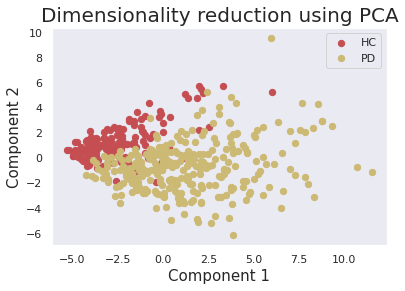

In [ ]:
fig=plt.figure(figsize=(6,4))  
ax=fig.add_subplot(1,1,1)  
ax.set_xlabel('Component 1',fontsize = 15)  
ax.set_ylabel('Component 2',fontsize = 15)  
ax.set_title('Dimensionality reduction using PCA',fontsize=20) 
colors = ['r','y']
targets = ['HC','PD']
target = merged_data["info"].ENROLL_CAT
#target = db_selected.iloc[:,-1]
for target,color in zip(targets,colors):    
     indicesToKeep = merged_data["info"].ENROLL_CAT == target  
     ax.scatter(m_pca.loc[indicesToKeep,'p1'], m_pca.loc[indicesToKeep,'p2'], c=color, s=40)
ax.legend(targets)  
ax.grid()

**Technique 2:** Nonnegative Matrix Factorization (NMF)\
\
NMF is an alternative technique for decomposition of variables that assumes data and the components to be non-negative. Unlike PCA, which tends to group both positively as well as negatively correlated components together. NMF tends to finds patterns amoung variable with the same direction of correlation.

In [ ]:
nmf_targets = ['n1','n2']
#db = db_minmax.drop(['ENROLL_CAT'], axis=1)

m_nmf = pd.DataFrame(index=db_selected.index, columns=nmf_targets) 
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
m_nmf[['n1', 'n2']] = model_NMF.fit_transform(db_selected)
#m_nmf = pd.concat([m_nmf,db_minmax[['ENROLL_CAT']]],axis=1)
m_nmf.head(3)

,n1,n2
PATNO,,
3000,0.854110,0.091709
3001,0.658744,0.498369
3002,0.325762,0.839209


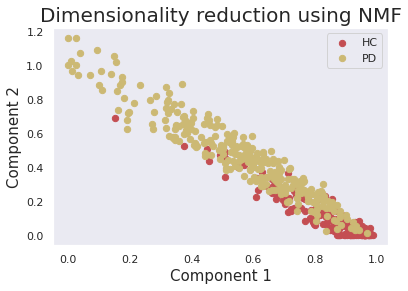

In [ ]:
fig=plt.figure(figsize=(6,4))  
ax=fig.add_subplot(1,1,1)  
ax.set_xlabel('Component 1',fontsize = 15)  
ax.set_ylabel('Component 2',fontsize = 15)  
ax.set_title('Dimensionality reduction using NMF',fontsize=20) 
colors = ['r','y']
targets = ['HC','PD']
target = merged_data["info"].ENROLL_CAT
#target = m_nmf.iloc[:,-1]
for target,color in zip(targets,colors):    
     indicesToKeep = merged_data["info"].ENROLL_CAT == target 
     ax.scatter(m_nmf.loc[indicesToKeep,'n1'], m_nmf.loc[indicesToKeep,'n2'], c=color, s=40)
ax.legend(targets)  
ax.grid()

**Inferrence**

NMF is best suited for clustering with non-negative data and over gaussian data. And as MinMax Normalization technique results in non-negetive datapoint values between 0-1 and data is gaussian in nature, NMF technique is adopeted. It finds sparse and parts-based representation of the data. Whereas, PCA it is ideal for pattern recognition and dimension reduction.

###**Unsupervised Clustering**

Clustering based on Gaussian Mixture Modelling (GMM) techniques generates data clusters by grouping similar data points based on their feature and correlation between the points. In proposed design data points are grouped into 3 clusters, where each cluster defines the risk of PD progression among the patient. These clusters are marked as Low, Medium and High referencing to progression rate.


In [ ]:
clus_col = ['GMM']
clus_lable = pd.DataFrame(index=db_selected.index, columns=clus_col)
clus_lable[ db_selected_labled.ENROLL_CAT == "HC" ] = 'HC'

gmm_chosen = m_pca #m_pca #m_nmf
gmm_chosen_pd = gmm_chosen[ db_selected_labled.ENROLL_CAT == "PD" ]
gmm_chosen_pd_hc = gmm_chosen[ db_selected_labled.ENROLL_CAT.isin(['HC', 'PD'])]

model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=10)
model_gmm.fit(gmm_chosen_pd)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=10, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

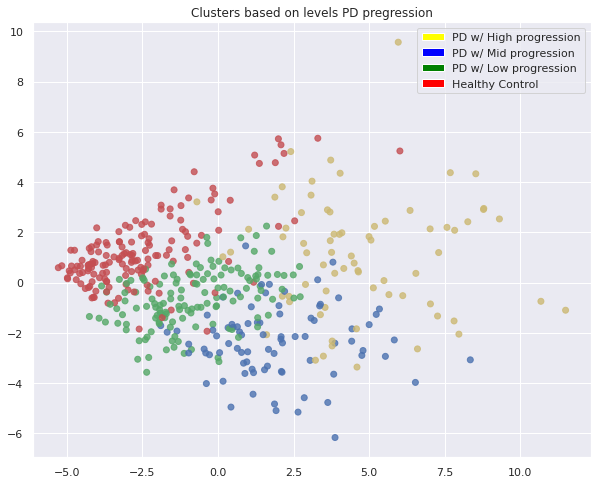

In [ ]:
clus_lable.loc[ db_selected_labled.ENROLL_CAT == "PD", 'GMM' ] = model_gmm.predict(gmm_chosen_pd)
clus_lable.replace([1,0,2],['PD_l', 'PD_m', 'PD_h'], inplace=True)
clus_lable_pd = clus_lable[db_selected_labled.ENROLL_CAT.isin(['PD'])]
clus_lable_pd_hc = clus_lable[db_selected_labled.ENROLL_CAT.isin(['HC', 'PD'])]

# plot predicted PD and HC
plt.figure(figsize=(10, 8))
colors = ['r' if i=='HC' else 'g' if i=='PD_l' else 'b' if i=='PD_m' else 'y' if i=='PD_h' else 'black' for i in clus_lable_pd_hc['GMM']]
ax = plt.scatter(gmm_chosen_pd_hc.iloc[:,0], gmm_chosen_pd_hc.iloc[:,1], c=colors, alpha=0.8)#gca()
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
plt.legend((p1, p2, p3, p4), ('PD w/ High progression', 'PD w/ Mid progression', 'PD w/ Low progression', 'Healthy Control'), loc='best')
plt.title('Clusters based on levels PD pregression')
plt.show()

Above scatter plot represents the colored distribution of generated clusters.  

###Ensemble Models

For the purpose of study, a comparative study on various classification algorithm is conducted to determine the classification accuracy on this dataset. Models trained for purpose of Study are,
1. Nearest Neighbors
2. Support Vector Machine
3. Decision Tree
4. Random Forest Classifier
5. AdaBoost
6. XGBoost
7. Multi-Layer Perceptron Model

**Step 1: Splitting Dataset into Train and Test data**

In [ ]:
from sklearn.model_selection import train_test_split

random.seed(123)
#Splitting Data into train and test datasets
X = db_selected.loc[clus_lable_pd_hc.index, db_selected.columns.get_level_values(1)=='BL'] 
X = X.stack().reset_index().set_index('PATNO').drop('EVENT_ID',axis =1)
Y = clus_lable_pd_hc.GMM.replace(['HC', 'PD_l', 'PD_m', 'PD_h'], [0, 1, 2, 3])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

 **Step 2: Training Classification Models**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


classifier_names = ["Nearest Neighbors", "SVM", "Decision Tree", "Random Forest Classifier", 
                    "AdaBoost", "XGBoost"]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", C=0.025, class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    XGBClassifier()]

scores = []
for n, c in zip(classifier_names, classifiers):
    c.fit(X_train, Y_train)
    score = c.score(X_test, Y_test)
    scores.append(score)

**Step 3: Model Performance Comparision**

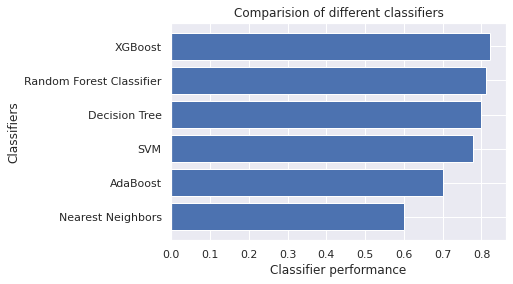

In [ ]:
plt.figure(1, figsize=(6, 4))
imp, names = zip(*sorted(zip(scores, classifier_names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifiers')
plt.title('Comparision of different classifiers')
plt.show()

###**Multilayer Perceptron Model**

After testing various structural combinations of layers and hyperparametrs, adopted state of art delivers model with best performance. In order to improve performance regularisation using Dropout layers are added and activation fuction Relu and Softmax are used in the structured model.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

nn_model  = Sequential()
nn_model.add(Dense(units= 100, activation= 'relu', input_dim= 235))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units= 10, activation= 'relu'))
nn_model.add(Dense(units= 4,  activation= 'softmax'))

nn_model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               23600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 24,654
Trainable params: 24,654
Non-trainable params: 0
_________________________________________________________________


Early stop function is assigned to training function to monitor the training rate and prevent overfitting. Model checkpoint saves model at every stage of improvement to deliver best perfoming model as resultant.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('nn_model.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
history = nn_model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_split=0.25 ,verbose=2, callbacks=[es, mc])

Epoch 1/50

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.35556, saving model to nn_model.h5
9/9 - 0s - loss: 1.4158 - sparse_categorical_accuracy: 0.3694 - val_loss: 1.3099 - val_sparse_categorical_accuracy: 0.3556
Epoch 2/50

Epoch 00002: val_sparse_categorical_accuracy improved from 0.35556 to 0.42222, saving model to nn_model.h5
9/9 - 0s - loss: 1.2761 - sparse_categorical_accuracy: 0.4104 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.4222
Epoch 3/50

Epoch 00003: val_sparse_categorical_accuracy improved from 0.42222 to 0.45556, saving model to nn_model.h5
9/9 - 0s - loss: 1.2273 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.1922 - val_sparse_categorical_accuracy: 0.4556
Epoch 4/50

Epoch 00004: val_sparse_categorical_accuracy improved from 0.45556 to 0.54444, saving model to nn_model.h5
9/9 - 0s - loss: 1.1312 - sparse_categorical_accuracy: 0.5149 - val_loss: 1.1243 - val_sparse_categorical_accuracy: 0.5444
Epoch 5/50

Epoch 00005: val_sparse

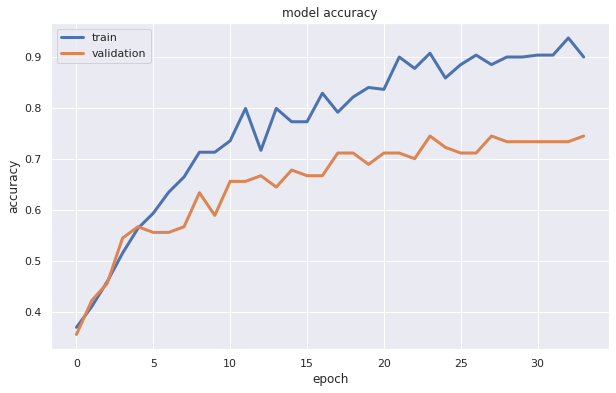

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['sparse_categorical_accuracy'],linewidth=3.0)
plt.plot(history.history['val_sparse_categorical_accuracy'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

Train and validation accuracy are pretty close and following each other. Thus, we’re not overfitting the data. Also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size is likely to give us a higher accuracy.

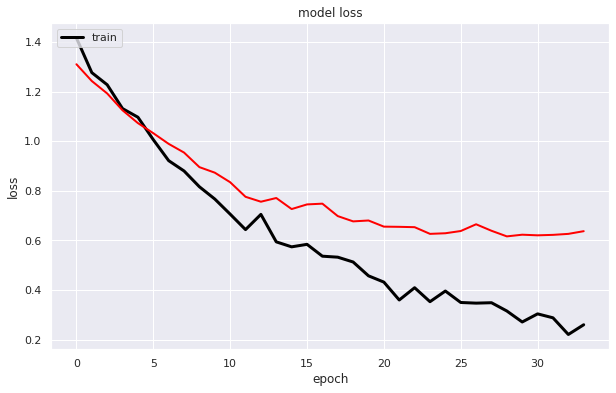

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='black',linewidth=3.0)
plt.plot(history.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

From losses curve, it can be visualised that data is not overfitting as both train and validation loss are trends down closely and the losses go lower with increasing number of epochs.

In [ ]:
nn_pred = nn_model.predict(X_test)
nn_pred = (nn_pred>0.5)
nn_pred = nn_pred.astype(int)
nn_pred[0]


array([1, 0, 0, 0])

In [ ]:
nn_result = pd.DataFrame(index=Y_test.index, columns=[['HC', 'PD_l', 'PD_m', 'PD_h', 'actual', 'pred']]) 
nn_result[['HC', 'PD_l', 'PD_m', 'PD_h']] = nn_pred
nn_result[['actual']] = Y_test
nn_result = nn_result.reset_index()

for i in range(len(nn_result)):
  if nn_result.loc[i,'HC'][0].astype(int) == 1:
    nn_result.loc[i,'pred'] = 'HC'
  elif nn_result.loc[i,'PD_l'][0].astype(int) == 1:
    nn_result.loc[i,'pred'] = 'PD_l'
  elif nn_result.loc[i,'PD_m'][0].astype(int) == 1:
    nn_result.loc[i,'pred'] = 'PD_m'
  else:
    nn_result.loc[i,'pred'] = 'PD_h'


for i in range(len(nn_result)):
  if nn_result.loc[i,'actual'][0] == 0:
    nn_result.loc[i,'actual'] = 'HC'
  elif nn_result.loc[i,'actual'][0] == 1:
    nn_result.loc[i,'actual'] = 'PD_l'
  elif nn_result.loc[i,'actual'][0] == 2:
    nn_result.loc[i,'actual'] = 'PD_m'
  else:
    nn_result.loc[i,'actual'] = 'PD_h'

nn_result.head(5)

,PATNO,HC,PD_l,PD_m,PD_h,actual,pred
0,3620,1,0,0,0,HC,HC
1,3651,1,0,0,0,HC,HC
2,3264,1,0,0,0,HC,HC
3,3812,1,0,0,0,HC,HC
4,3169,1,0,0,0,HC,HC


Above table represents comparision of actual value and predicted value of Test set data. 

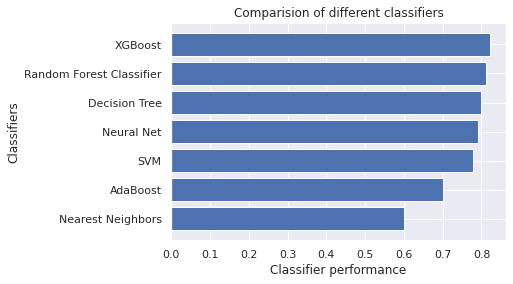

In [ ]:
scores.append(round(metrics.accuracy_score(nn_result[['actual']],nn_result[['pred']]),2))
classifier_names.append('Neural Net')

plt.figure(1, figsize=(6, 4))
imp, names = zip(*sorted(zip(scores, classifier_names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifiers')
plt.title('Comparision of different classifiers')
plt.show()

Above visualization, illustrates the comparision of models based on its prediction accuracy. It can be infered that Support Vector Machine (SVM) is the best performing model when data is clustered using NMF component vector, with 87% classification accuracy. 

##**Evaluation of Best Model**
Various evaluation metrics are applied to evalute best performing model, Logistic Regression model
1. **Matthews Correlation Coefficient:** 
\
MCC is calculated from confusion matrix and it represents the correlation between observed and predicted classification. Here, if the value of MCC is 1 then it is perfect prediction if it is -1 then it is total disagreement and if it is 0, it means it is a random guess.

2. **Precision:**
\
Precision is
the ratio of true positive to number of positives in the result. It
ranges from 0 – 1.

3. **Recall:**
\
Recall is the proportion of true positive by all possible
relevant data. ie. proportion of actual positives
that are correctly identified.

4. **F1-Score:**
\
It is a harmonic mean of precision and recall and is also
known as f1 measure. The value ranges from 0 to 1 and a high
value of f1 score represents high classification performance.

5. **Confusion Metrix:**
\
By using this
matrix, we can identify which category is correctly classified
and which does not.

In [ ]:
model = SVC(kernel="linear", C=0.025, gamma= 0.0001, class_weight='balanced')
model.fit(X_train, Y_train)

SVC(C=0.025, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
#BEST PERFORMING MODEL FOR PCA BASED DIMENSIONALITY REDUCTION
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
Y_pred = model.predict(X_test)

print("Evalution Result for SVM model\n") 
print("Matthews Correlation Coefficient:", round(metrics.matthews_corrcoef(Y_test,Y_pred),3))
print('Accuracy:',round(metrics.accuracy_score(Y_test,Y_pred),3))  
print('F1 score:',round(metrics.f1_score(Y_test,Y_pred,average='weighted'),3))   
print('Recall:',round(metrics.recall_score(Y_test,Y_pred,average='weighted'),3))   
print('Precision:',round(metrics.precision_score(Y_test,Y_pred,average='weighted'),3))  
print('\n clasification report:\n',metrics.classification_report(Y_test,Y_pred))  
confusion_mtx = metrics.confusion_matrix(Y_test,Y_pred)
print('\n confussion matrix:\n',confusion_mtx)

Evalution Result for SVM model

Matthews Correlation Coefficient: 0.749
Accuracy: 0.822
F1 score: 0.816
Recall: 0.822
Precision: 0.823

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.76      0.90      0.82        31
           2       0.50      0.45      0.48        11
           3       0.82      0.56      0.67        16

    accuracy                           0.82        90
   macro avg       0.77      0.73      0.74        90
weighted avg       0.82      0.82      0.82        90


 confussion matrix:
 [[32  0  0  0]
 [ 0 28  1  2]
 [ 0  6  5  0]
 [ 0  3  4  9]]


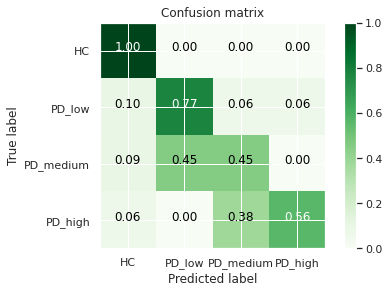

In [ ]:
def plot_confusion_matrix(cm, classes,
   normalize=True,
   title= 'Confusion matrix',
   cmap=plt.cm.Greens):
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=0)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

plt.figure(figsize=(6,4))
plot_confusion_matrix(confusion_mtx, ['HC', 'PD_low', 'PD_medium', 'PD_high'])

##Result Discussion

In this research, performance of 7 different models are compared. Based on thorough evaluation of model with optimal selection of myper parameters. Best performing model is SVM based model with classification prediction accuracy of 87%. 